## Set up environment and import data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### read json as dataframe

In [ ]:
json_file='/content/drive/My Drive/NLP Project/reviews_Electronics_5.json'
df = pd.read_json(json_file, lines=True)

In [ ]:
df = df.rename(columns={'asin':'product_id'})

In [ ]:
df.drop(columns=['helpful', 'reviewerName', 'unixReviewTime', 'reviewTime'], inplace=True)

In [ ]:
df.head()

,reviewerID,product_id,reviewText,overall,summary
0,AO94DHGC771SJ,0528881469,We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!
1,AMO214LNFCEI4,0528881469,"I'm a professional OTR truck driver, and I bou...",1,Very Disappointed
2,A3N7T0DY83Y4IG,0528881469,"Well, what can I say. I've had this unit in m...",3,1st impression
3,A1H8PY3QHMQQA0,0528881469,"Not going to write a long review, even thought...",2,"Great grafics, POOR GPS"
4,A24EV6RXELQZ63,0528881469,I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   reviewerID  1689188 non-null  object
 1   product_id  1689188 non-null  object
 2   reviewText  1689188 non-null  object
 3   overall     1689188 non-null  int64 
 4   summary     1689188 non-null  object
dtypes: int64(1), object(4)
memory usage: 64.4+ MB


In [ ]:
df.nunique()

reviewerID     192403
product_id      63001
reviewText    1687169
overall             5
summary       1139738
dtype: int64

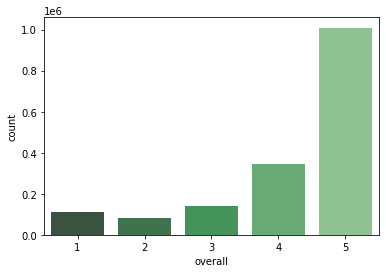

In [ ]:
pal = sns.color_palette("Greens_d", 5)
sns.countplot(x="overall", data=df, palette=np.array(pal[::-1]))

In [ ]:
review = df['reviewText'].apply(lambda x: len(x))
review.describe()
summary = df['summary'].apply(lambda x: len(x))
summary.describe()

count    1.689188e+06
mean     2.613683e+01
std      1.654165e+01
min      1.000000e+00
25%      1.400000e+01
50%      2.200000e+01
75%      3.400000e+01
max      2.920000e+02
Name: summary, dtype: float64

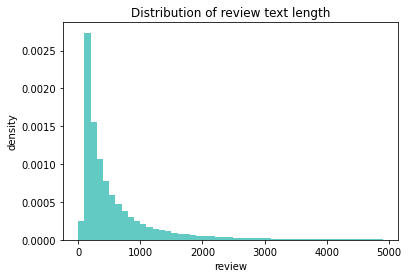

In [ ]:
plt.hist(review, bins=range(0,5000,100),color='lightseagreen',density=True,alpha=0.7)
plt.title('Distribution of review text length')
plt.xlabel('review')
plt.ylabel('density')
plt.show()

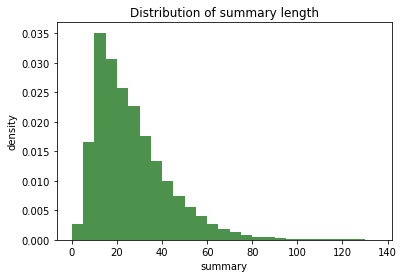

In [ ]:
plt.hist(summary, bins=range(0,140,5),color='darkgreen',density=True,alpha=0.7)
plt.title('Distribution of summary length')
plt.xlabel('summary')
plt.ylabel('density')
plt.show()

In [ ]:
# Remove missing value
df.dropna(subset=['reviewText'],inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689188 entries, 0 to 1689187
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   reviewerID  1689188 non-null  object
 1   product_id  1689188 non-null  object
 2   reviewText  1689188 non-null  object
 3   overall     1689188 non-null  int64 
 4   summary     1689188 non-null  object
dtypes: int64(1), object(4)
memory usage: 77.3+ MB


## Tokenizing

In [ ]:
####limiting dataset for faster processing time
df = df[:10000]
len(df)

10000

In [ ]:
# use the first 10000 data as our training data
data = df.loc[:9999, 'reviewText'].tolist()
len(data)

10000

In [ ]:
data = [k.lower() for k in data]

In [ ]:
df['reviewText'][0]

'We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!'

# Topic Modeling using LDA

In [ ]:
import nltk; nltk.download('stopwords')
import spacy; nlp = spacy.load("en")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(df.reviewText))
print(data_words[:1])

[['we', 'got', 'this', 'gps', 'for', 'my', 'husband', 'who', 'is', 'an', 'otr', 'over', 'the', 'road', 'trucker', 'very', 'impressed', 'with', 'the', 'shipping', 'time', 'it', 'arrived', 'few', 'days', 'earlier', 'than', 'expected', 'within', 'week', 'of', 'use', 'however', 'it', 'started', 'freezing', 'up', 'could', 'of', 'just', 'been', 'glitch', 'in', 'that', 'unit', 'worked', 'great', 'when', 'it', 'worked', 'will', 'work', 'great', 'for', 'the', 'normal', 'person', 'as', 'well', 'but', 'does', 'have', 'the', 'trucker', 'option', 'the', 'big', 'truck', 'routes', 'tells', 'you', 'when', 'scale', 'is', 'coming', 'up', 'ect', 'love', 'the', 'bigger', 'screen', 'the', 'ease', 'of', 'use', 'the', 'ease', 'of', 'putting', 'addresses', 'into', 'memory', 'nothing', 'really', 'bad', 'to', 'say', 'about', 'the', 'unit', 'with', 'the', 'exception', 'of', 'it', 'freezing', 'which', 'is', 'probably', 'one', 'in', 'million', 'and', 'that', 'just', 'my', 'luck', 'contacted', 'the', 'seller', 'and

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc 
                          if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['get', 'trucker', 'impress', 'shipping', 'time', 'arrive', 'day', 'earlier', 'expect', 'week', 'however', 'start', 'freeze', 'could', 'glitch', 'unit', 'work', 'great', 'worked', 'work', 'great', 'normal', 'person', 'trucker', 'option', 'big', 'truck', 'route', 'tell', 'scale', 'come', 'ect', 'love', 'big', 'screen', 'ease', 'ease', 'putting', 'address', 'memory', 'really', 'bad', 'say', 'unit', 'exception', 'freeze', 'probably', 'luck', 'contact', 'seller', 'minute', 'email', 'receive', 'email', 'instruction', 'exchange', 'impress', 'way', 'around']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 2), (46, 1), (47, 1), (48, 2), (49, 1)]]


### Building the topic model

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=22, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(7,
  '0.084*"order" + 0.077*"strap" + 0.051*"quickly" + 0.041*"spare" + '
  '0.038*"key" + 0.036*"service" + 0.031*"black" + 0.031*"handy" + '
  '0.023*"soon" + 0.022*"hd"'),
 (13,
  '0.070*"sharp" + 0.040*"fold" + 0.034*"lock" + 0.034*"tight" + '
  '0.024*"lighting" + 0.020*"single" + 0.019*"various" + 0.016*"thick" + '
  '0.016*"panasonic" + 0.016*"extension"'),
 (1,
  '0.080*"month" + 0.075*"radio" + 0.029*"extremely" + 0.028*"ago" + '
  '0.025*"talk" + 0.025*"remember" + 0.023*"station" + 0.022*"relatively" + '
  '0.022*"area" + 0.021*"vacation"'),
 (9,
  '0.051*"support" + 0.048*"open" + 0.046*"view" + 0.044*"user" + '
  '0.044*"attach" + 0.039*"amazing" + 0.029*"kit" + 0.025*"similar" + '
  '0.022*"certainly" + 0.022*"plenty"'),
 (16,
  '0.147*"cable" + 0.137*"shot" + 0.062*"store" + 0.045*"box" + 0.029*"tie" + '
  '0.027*"application" + 0.024*"wireless" + 0.022*"installation" + '
  '0.019*"rebel" + 0.018*"local"'),
 (4,
  '0.112*"image" + 0.038*"difference" + 0.037*"piece" + 0

In [ ]:
# Compute Coherence Score
#The higher the coherence score the better, we will use this to find the best number of topics
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.31352554403417154


In [ ]:
#Using the conference score to estimate the best number of topics

for i in range(10,25,2):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=i, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('when num_topics = ' + str(i) + ', coherence score = ' + str(coherence_lda))

when num_topics = 10, coherence score = 0.3031610452691428
when num_topics = 12, coherence score = 0.3161742843854096
when num_topics = 14, coherence score = 0.3252234428195491
when num_topics = 16, coherence score = 0.3603656693040588
when num_topics = 18, coherence score = 0.31255563541244813
when num_topics = 20, coherence score = 0.3149534106547161
when num_topics = 22, coherence score = 0.31352554403417154
when num_topics = 24, coherence score = 0.30316948082630324


In [ ]:
#best num_topics is 14
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.093*"bag" + 0.048*"pocket" + 0.046*"carry" + 0.034*"palm" + 0.034*"color" '
  '+ 0.033*"pc" + 0.031*"read" + 0.027*"month" + 0.023*"away" + '
  '0.017*"sometimes"'),
 (1,
  '0.090*"quot" + 0.089*"perfect" + 0.039*"pda" + 0.030*"usually" + '
  '0.020*"wide" + 0.018*"complain" + 0.018*"area" + 0.018*"nearly" + '
  '0.017*"vacation" + 0.015*"desk"'),
 (2,
  '0.045*"hear" + 0.037*"wear" + 0.029*"pack" + 0.025*"simply" + 0.023*"cover" '
  '+ 0.023*"protect" + 0.021*"call" + 0.018*"tie" + 0.017*"care" + '
  '0.017*"service"'),
 (3,
  '0.034*"get" + 0.029*"time" + 0.026*"go" + 0.021*"even" + 0.019*"still" + '
  '0.017*"year" + 0.016*"thing" + 0.016*"see" + 0.014*"take" + 0.013*"first"'),
 (4,
  '0.164*"camera" + 0.066*"picture" + 0.059*"take" + 0.053*"flash" + '
  '0.044*"battery" + 0.029*"film" + 0.026*"image" + 0.018*"digital" + '
  '0.016*"mode" + 0.015*"router"'),
 (5,
  '0.038*"card" + 0.033*"problem" + 0.032*"computer" + 0.027*"unit" + '
  '0.021*"software" + 0.021*"old" + 0.0

In [ ]:
#Identify dominant topic for all reviews
review_topics = []

for i, row in enumerate(lda_model[corpus]):
  row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
  review_topics.append(row[0][0])



In [ ]:
#Get words for each topic
review_topics_word = []
for i in review_topics:
  wp = lda_model.show_topic(i)
  topic_keywords = ", ".join([word for word, prop in wp])
  review_topics_word.append(topic_keywords)

In [ ]:
df['Topic#'] = review_topics
df['Topic_words'] = review_topics_word
df.head()

,reviewerID,product_id,reviewText,overall,summary,Topic#,Topic_words
0,AO94DHGC771SJ,0528881469,We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,3,"get, time, go, even, still, year, thing, see, ..."
1,AMO214LNFCEI4,0528881469,"I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,3,"get, time, go, even, still, year, thing, see, ..."
2,A3N7T0DY83Y4IG,0528881469,"Well, what can I say. I've had this unit in m...",3,1st impression,3,"get, time, go, even, still, year, thing, see, ..."
3,A1H8PY3QHMQQA0,0528881469,"Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",3,"get, time, go, even, still, year, thing, see, ..."
4,A24EV6RXELQZ63,0528881469,I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",3,"get, time, go, even, still, year, thing, see, ..."


In [ ]:
# Recommend new product to a random user
def recommendation(reviewerID, df):
  subset_user = df[df['reviewerID'] == reviewerID].copy()
  subset_user.sort_values('overall', ascending=False, inplace=True)
  topic_n = subset_user['Topic#'].iloc[0]
  subset_topic = df[df['Topic#'] == topic_n].copy()
  subset_topic.sort_values('overall', ascending=False, inplace=True)
  product_n = subset_topic['product_id'].iloc[0]
  print("reviewerID = " + str(reviewerID))
  print("This reviewer's favorite topic is topic number " + str(topic_n))
  print("Based on favorite topic number, product number " + str(product_n) + " is recommended")

import random
number = random.randrange(0, len(df))
reviewerID = df.iloc[number, 0]
recommendation(reviewerID, df)

reviewerID = AIMV33HXTEZOI
This reviewer's favorite topic is topic number 11
Based on favorite topic number, product number 0594451647 is recommended


In [ ]:
# This is the example on the PowerPoint deck
recommendation('A392YS0W837HFU', df)

reviewerID = A392YS0W837HFU
This reviewer's favorite topic is topic number 4
Based on favorite topic number, product number B00004R8VE is recommended


In [ ]:
# Overview of the example
df[df['reviewerID']=="A392YS0W837HFU"]

,reviewerID,product_id,reviewText,overall,summary,Topic#,Topic_words
2988,A392YS0W837HFU,B00000JYLO,A wonderful camera for Intrnet use. For auctio...,4,"A Wonferful Camera for Internet Use, NOT PHOTOS",4,"camera, picture, take, flash, battery, film, i..."


In [ ]:
# Detailed review text for this user
df[df['reviewerID']=="A392YS0W837HFU"].iloc[0, 2]

'A wonderful camera for Intrnet use. For auctions, emails, web sites, Etc. this is a fine camera. The advantages are great macros (down to 1&quot;),10X zoom lens, comes with rechagable battery and charger, simple downloading of floppies to your PC and the economy of using floppies as the storage medium.  However this is NOT a camera suitable for Photos (Because of the 640X480 resolution) Do not make the mistake of taking important shots and assume you can get decent photos. For fine photos go to a 1 or 2 megapixel cameras. I also own the Nikon Coolpix 950 camera and recommend any Nikon or Olympus camera. Only the Nikons have great Macro capability (If this is important) A great buy for the money is the Olympus 460/490.'

In [ ]:
# purchased item review
df[df['product_id']=="B00000JYLO"]['reviewText'].iloc[3]

"The Mavica MVC-73 is a good low end camera.  If I want to blow up my pictures to 16X20, I use my 35mm SLR.  Megapixel cameras do take better pictures but they require EXPENSIVE memory cards.  The camera takes great shots for web sites and email.  If you shop around, floppies cost almost nothing.  With a rebate, I bought 100 floppies.  I put 10 of them in a bag and I took over 200 photos. (It would have cost me hundreds of dollars to save that many pictures on memory cards.) They used up less room than two rolls of film.  The recharable battery lasts forever and I can go out and take hundreds of photos without having to dump the memory card.  Achiving the photos uses little disk space on my hard drive.  The camera is very easy to use and in the long run pays for itself on the savings on film development, batteries or extra memory.  I give copies of disks right on the spot and the camera is very reliable. If you are looking for a good &quot;snapshot&quot; camera, this is a good one.  Th

In [ ]:
# average rating for the purchased item
print(df[df['product_id']=="B00000JYLO"]['overall'].mean())
# the number of ratings for the purchased item
print(df[df['product_id']=="B00000JYLO"].count())

4.166666666666667
reviewerID     12
product_id     12
reviewText     12
overall        12
summary        12
Topic#         12
Topic_words    12
dtype: int64


In [ ]:
# recommended item review
df[df['product_id']=="B00004R8VE"]['reviewText'].iloc[0]

"I'll try not to repeat the rave reviews that others have given the Olympus  C3030 but I thought I would counter a couple comments I saw about a  supposedly flawed view finder, battery compartment flap, and the battery  for the remote control.  One person commented that it took him 15 minutes  to figure out the camera battery flap which he ended up breaking.  Without  reading the manual it took me no time at all to install 4 AA batteries and  I had the camera up and running immediately without a hitch - or breaking  anything.  There was nothing wrong with my remote control or the battery,  and camera view finder works as it should.  The one very minor flaw is that  if you power up the camera with the lens cap over the lens, the zoom lens  tries to push outward causing the a grinding sound.  Its happend to me a  couple times but didn't cause any damage and I'm more careful now to take  the lens cap off before powering up the camera.This camera is awesome!  Others have written about its 

In [ ]:
# average rating for the recommended item
print(df[df['product_id']=="B00004R8VE"]['overall'].mean())
# the number of ratings for the recommended item
print(df[df['product_id']=="B00004R8VE"].count())

4.75
reviewerID     16
product_id     16
reviewText     16
overall        16
summary        16
Topic#         16
Topic_words    16
dtype: int64
